# BroadBand data clustering and bootstraping
In this project, the broadband acoustics data is clustered by KM, AC and other algorithms and methods. 
The aim is to find a suitable clustering number of species of the scene.


Specifically, this code is to obtain the reflectances of possible species (unsupervised clusters) in the broadband acoustic dataset. 

Note that both test data and the larger data will be used to see which one is more resonable to biologists.

For details about the project and tasks, 
please contact: Mette DalGaard Agersted (mette.dalgaard.agersted@hi.no) & Yi Liu (yi.liu@hi.no)

### 1. The experimental settings & input:
+ Experimental data
  1. The test dataset (better quality, correct me if I'm wrong)
  2. The large survey data
+ Data clearning
  1. Drop irrelevant items (time/depth,Alo, Ath, PingNo, Range, etc.)
  2. Choose frequencies from 54 to 78 kHz (excluding the lowest frequencies for something 'strange' with the data)
  3. Discard no-value samples for "not a number" Nan in this case
  4. Discard samples that record either too week reflectance (noisy) or too strong (seabed for example that's irrelavent)
+ Preprocessing - Dimension reduction
  1. PCA - for visualization purposes
  2. Original - for clustering (see earlier work that shows KM and AC are capable of handling this high dimensionality)
+ Using algorithms (KM & AC):
  1. *__K-Means__
  1. AP (Affiliation Propagation) (**not scalable**)
  2. AAP (Ajusted Affiliation Propagation) (**not scalable**)
  3. Spectral Clustering (**not scalable**)
  4. Mean-Shift  (**not scalable**)
  5. *__Agglomerative Clustering__
  6. DBSCAN
  7. HDBSCAN
  
### 2. Progresses
#### 2.1 Spotted KM and AC algorithms out of the seven clustering methods and proceed with experiments on 
+ Test data - KM
+ Test data - AC
+ Survey data - KM
+ Survey data - AC

#### 2.2 PCA is not 'very' necessary for better clustering 
- PCA helps improve the clustered results, though not significantly
- PCA components help a lot in visualizing the distinguishing capability of a clustering method

#### 2.3 AC outperforms KM
- Idea - Clustering with the original data & visualizing in component space (transformed from original space)
- AC outperforms significantly KM in 
  1. more resonable clusters when scattered in pca space
  2. more resonable boundaries among clusters
  3. more robust result [always the same clustered results with random sampling repetations]

#### 2.4 Elbow algorithm suggest optimal cluster numbers [4, 8]
More specifically,
- raging cluster number from 4-8, similar results are obtained with more detailed targets spotted
- one anomaly target/cluster spotted with most samples locate at the same point

### 3. Experiment output
For each group above in **2**, **cluster numbers** are set to **[4,5,6,7,8]** so to be thorough. Along the frequency reflectance, **standard deviation** will also be plotted around o see variations. 

We confirmed that AC algorithm performs the best with the test and site dataset. Informative frequency reflectances have been obtained. 

### 4. Dataset Info.
Here's two differnt data files containing information on target strength at different frequencies for single targets.

- Each row is one target. All the columns names something like "F_.." are different frequencies and the corresponding values at a given frequency is the target strength for a given target at that given frequency.

- There are also columns including date, pingNo, Range (distance of target from the transducer), position in the beam (Alo and Ath) and depth. Depth is the last column after all the frequencies are listed. 


- When running the PCA (or AP) just use data from **54 to 78 kHz** (excluding the lowest frequencies as there is something strange with the data here).

- Note that the **first column** just contains running numbers and does not have a header.

In [1]:
import os
print(os.getcwd())

# from ISOData import isodata_classification #(img, parameters=None)
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.cluster as cluster
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

import plotly.graph_objects as go
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK=True
except: HAS_SK=False; print('Please install sklearn for layer visualization')
    
from colorama import Fore    
    
# from IPython.display import HTML as html_print
# def cstr(s, color='black'):
#     return "<text style=color:{}>{}</text>".format(color, s)

# left, word, right = 'foo' , 'abc' , 'bar'
# html_print(cstr(' '.join([left, cstr(word, color='red'), right]), color='black') )

/Users/yi.liu/Dropbox/Work@IMR/Clustering-Braodband-master


## Check files in the path

In [2]:
# !ls /mnt/d/Data/broadband\ sonar/
!ls -l
print('\n from path:\n')
!pwd


total 242200
-rw-r--r--@  1 yi.liu  ITERA\Domain Users    671617 Oct 16 10:52 Asistant_code.ipynb
-rw-r--r--@  1 yi.liu  ITERA\Domain Users    447483 Oct 15 15:34 Broadband_Obtain_Reflectances-Oct2020-15.ipynb
-rw-r--r--@  1 yi.liu  ITERA\Domain Users   7893527 Oct 26 15:07 Broadband_Obtain_Reflectances-Oct2020-CNN.ipynb
-rw-r--r--@  1 yi.liu  ITERA\Domain Users     72538 Oct 16 10:02 Broadband_Obtain_Reflectances-Oct2020-Copy1.ipynb
-rw-r--r--@  1 yi.liu  ITERA\Domain Users   1020665 Oct 16 09:49 Broadband_Obtain_Reflectances-Oct2020-Copy2.ipynb
-rw-r--r--@  1 yi.liu  ITERA\Domain Users   7397306 Oct 16 18:09 Broadband_Obtain_Reflectances-Oct2020.ipynb
-rw-r--r--@  1 yi.liu  ITERA\Domain Users     19691 Oct  4 14:19 Broadband_Obtain_Reflectances.ipynb
-rw-r--r--@  1 yi.liu  ITERA\Domain Users   2204675 Sep  2 17:49 Broadband_clustering.ipynb
-rw-r--r--@  1 yi.liu  ITERA\Domain Users    968127 Oct 15 17:57 Broadband_clustering_ex01.ipynb
-rw-r--r--@  1 yi.liu  ITERA\Domain Users     16

## Read dataset. Choose between the two datasets:
+ TS_st.127.csv
+ TS_MESSOR_AllStations.csv

In [3]:
try: 
    from google.colab import drive
    colab_mode = True
    drive.mount('/content/gdrive')
    !pip install colorama
    !cd /
except: colab_mode=False

In [4]:
filepaths = ["/mnt/d/Data/broadband sonar/",         # ASUS subsystem
             "/home/deep/deep/data/broadband",       # pallas/styx servers
             "/home/personal/data/Mette_Agersted",   # thinkpad
             "/Users/yi.liu/OneDrive - Itera/Data",  # macbook
             "gdrive/My Drive/Data",                 # google drive
            ]
# print("Files in the data folder: \n", os.listdir(filepath))

filename = "TS_MESSOR_AllStations.csv"  #  "TS_st.127.csv" #  # "TS_MESSOR_AllStations.csv"

for fp in filepaths:
    if  os.path.exists(os.path.join(fp, filename)):
        print("\nData found at : %s. Reading ..." % fp)
        f = pd.read_csv(os.path.join(fp, filename), header=0)
    else:
        print("File not existing in %s, please check." % fp)

        # with  pd.read_csv(os.path.join(filepath, filename), header=0) as f:
# pd.read_csv(os.path.join(filepath, filename), header=0)

File not existing in /mnt/d/Data/broadband sonar/, please check.
File not existing in /home/deep/deep/data/broadband, please check.
File not existing in /home/personal/data/Mette_Agersted, please check.

Data found at : /Users/yi.liu/OneDrive - Itera/Data. Reading ...
File not existing in gdrive/My Drive/Data, please check.


##### Visualize data details

In [5]:
print("*** Original data before cleaning")
f
# f.head()
# f.describe()

*** Original data before cleaning


Unnamed: 0                     Date   PingNo   Range   Alo   Ath  \
0             48557  2019-05-03 21:00:00.089  13695.0  15.563  0.75  2.24   
1             48558  2019-05-03 21:00:00.089  13695.0  24.695  0.64  1.45   
2             48559  2019-05-03 21:00:00.339  13696.0  11.687  2.61  0.64   
3             48560  2019-05-03 21:00:00.339  13696.0  15.612 -1.52  2.36   
4             48561  2019-05-03 21:00:00.339  13696.0  24.744 -1.05  1.48   
...             ...                      ...      ...     ...   ...   ...   
4380441    19312311  2019-05-22 06:33:46.178  53978.0  33.375 -0.25  2.91   
4380442    19312411  2019-05-22 06:33:46.178  53978.0  33.889  1.49  1.61   
4380443    19312511  2019-05-22 06:33:46.178  53978.0  35.649  2.71  0.96   
4380444    19312611  2019-05-22 06:33:46.178  53978.0  38.498 -1.87 -0.75   
4380445    19312711  2019-05-22 06:33:46.178  53978.0  38.999  0.21  3.38   

         F_52000  F_53000  F_54000  F_55000  ...  F_70000  F_71000  F_72000  \
0         -59.47   -59.60   -60.95   -60.16  ...   -53.88   -54.32   -54.95   
1         -60.84   -66.91   -67.26   -67.67  ...   -55.11   -54.10   -53.81   
2         -62.16   -54.61   -59.02   -57.96  ...   -57.48   -57.81   -57.74   
3         -59.64   -59.09   -60.16   -59.01  ...   -52.76   -53.32   -54.12   
4         -59.92   -65.57   -66.36   -66.84  ...   -55.49   -54.37   -53.85   
...          ...      ...      ...      ...  ...      ...      ...      ...   
4380441   -68.21   -68.82   -70.25   -70.04  ...   -70.41   -70.27   -70.44   
4380442   -76.77   -77.10   -78.70   -78.09  ...   -68.08   -67.69   -67.33   
4380443   -72.80   -72.99   -74.39   -73.79  ...   -68.79   -68.91   -69.12   
4380444   -71.21   -71.36   -72.54   -71.79  ...   -69.31   -69.45   -69.70   
4380445   -73.51   -73.85   -75.18   -74.81  ...   -68.43   -68.69   -69.17   

         F_73000  F_74000  F_75000  F_76000  F_77000  F_78000       Depth  
0         -55.39   -55.82   -56.45   -56.85   -57.61   -58.04  829.116354  
1         -53.11   -52.85   -52.63   -52.53   -52.74   -52.87  829.116354  
2         -58.17   -58.16   -58.92   -59.12   -60.33   -61.26  829.068901  
3         -54.75   -55.32   -56.01   -56.28   -56.76   -56.85  829.068901  
4         -52.89   -52.33   -51.94   -51.67   -51.81   -51.94  829.068901  
...          ...      ...      ...      ...      ...      ...         ...  
4380441   -70.35   -70.33   -70.55   -70.66   -71.10   -71.37    9.489469  
4380442   -67.18   -66.89   -67.02   -66.95   -67.16   -67.49    9.489469  
4380443   -69.35   -69.50   -69.92   -70.03   -70.54   -71.03    9.489469  
4380444   -69.80   -69.80   -70.12   -70.15   -70.44   -70.64    9.489469  
4380445   -69.55   -69.95   -70.56   -71.04   -71.73   -72.32    9.489469  

[4380446 rows x 34 columns]

In [6]:
print("Basic statistics of data before clearning")
f.describe()

Basic statistics of data before clearning


Unnamed: 0        PingNo         Range           Alo           Ath  \
count  4.380446e+06  4.380446e+06  4.380446e+06  4.380446e+06  4.380446e+06   
mean   4.142936e+06  2.851600e+04  2.743341e+01 -5.381058e-02  5.647198e-02   
std    5.337844e+06  1.969330e+04  1.000483e+01  1.636214e+00  1.630147e+00   
min    7.339000e+03  1.000000e+01  0.000000e+00 -3.450000e+00 -3.390000e+00   
25%    1.153232e+06  9.988000e+03  2.187100e+01 -1.310000e+00 -1.190000e+00   
50%    2.266016e+06  3.010500e+04  2.973200e+01 -5.000000e-02  6.000000e-02   
75%    3.938269e+06  4.021800e+04  3.540500e+01  1.200000e+00  1.300000e+00   
max    4.117611e+07  1.019460e+05  4.014800e+01  3.460000e+00  3.510000e+00   

            F_52000       F_53000       F_54000       F_55000       F_56000  \
count  4.360626e+06  4.360626e+06  4.360626e+06  4.360626e+06  4.360626e+06   
mean  -6.335314e+01 -6.264839e+01 -6.446078e+01 -6.406489e+01 -6.353153e+01   
std    8.490364e+00  9.859577e+00  9.303255e+00  9.635745e+00  9.379546e+00   
min   -1.176700e+02 -1.183200e+02 -1.187800e+02 -1.222900e+02 -1.174000e+02   
25%   -6.700000e+01 -6.797000e+01 -6.928000e+01 -6.903000e+01 -6.827000e+01   
50%   -6.032000e+01 -5.973000e+01 -6.160000e+01 -6.118000e+01 -6.063000e+01   
75%   -5.799000e+01 -5.593000e+01 -5.821000e+01 -5.770000e+01 -5.740000e+01   
max    1.760000e+01  2.446000e+01  1.738000e+01  1.570000e+01  1.622000e+01   

       ...       F_70000       F_71000       F_72000       F_73000  \
count  ...  4.360626e+06  4.360626e+06  4.360626e+06  4.360626e+06   
mean   ... -6.346098e+01 -6.338689e+01 -6.373116e+01 -6.381342e+01   
std    ...  9.249796e+00  8.775063e+00  9.550103e+00  9.329257e+00   
min    ... -1.359300e+02 -1.239900e+02 -1.334000e+02 -1.360700e+02   
25%    ... -6.626000e+01 -6.613000e+01 -6.625000e+01 -6.626000e+01   
50%    ... -6.077000e+01 -6.082000e+01 -6.107000e+01 -6.118000e+01   
75%    ... -5.847000e+01 -5.856000e+01 -5.881000e+01 -5.893000e+01   
max    ...  2.249000e+01  2.257000e+01  2.211000e+01  2.198000e+01   

            F_74000       F_75000       F_76000       F_77000       F_78000  \
count  4.360626e+06  4.360626e+06  4.360626e+06  4.360626e+06  4.360626e+06   
mean  -6.396924e+01 -6.413254e+01 -6.429296e+01 -6.449881e+01 -6.495664e+01   
std    9.628827e+00  9.421894e+00  9.528505e+00  9.817972e+00  9.619486e+00   
min   -1.307900e+02 -1.343700e+02 -1.326600e+02 -1.364000e+02 -1.395000e+02   
25%   -6.627000e+01 -6.644000e+01 -6.646000e+01 -6.653000e+01 -6.704000e+01   
50%   -6.128000e+01 -6.147000e+01 -6.165000e+01 -6.169000e+01 -6.241000e+01   
75%   -5.903000e+01 -5.931000e+01 -5.944000e+01 -5.962000e+01 -6.002000e+01   
max    2.213000e+01  2.179000e+01  2.246000e+01  2.183000e+01  2.360000e+01   

              Depth  
count  4.380446e+06  
mean   4.546448e+02  
std    2.473432e+02  
min    3.620985e+00  
25%    3.202746e+02  
50%    4.909251e+02  
75%    6.145516e+02  
max    1.015681e+03  

[8 rows x 33 columns]

### Clean the data columns
- Select relavant frequencies from 54-78Khz 
- discard NaN values by row (samples) - No need for imputing since we have a LOT of samples
- discard samples with too weak (noisy) and strong (seabed for eg.) 

In [7]:
# Functions to use
def get_hist(fre):
    hist, bin_edges = np.histogram(fre, bins = 100)
#     print(hist.shape, bin_edges.shape, bin_edges)
    
    f, axs = plt.subplots(1,1, figsize = (15, 5))
    axs.plot(bin_edges[:-1], hist)
    plt.xlabel('TS')
#     plt.ylabel('Number')

# get percentiles
def get_percentiles(fre):
    percentiles = np.percentile(fre, (2.5, 99))
    return percentiles

# get thresholds
def get_threshold(fre):
    hist, bin_edges = get_hist(fre)
    pass

In [8]:
## Irrelevant fields & freqs to discard
col_irrelavent = ['Unnamed: 0', 'Date', 'Range', 'PingNo', 'Alo', 'Ath', 'Depth', 'F_52000', 'F_53000']
col_relevant = ["F_"+str(v) for v in range (54000, 78001, 1000)]

# for i, c in enumerate(col_irrelavent):
#     # print(i)
#     if not type(c) is str:
#         f.drop(f.columns[c], axis=1, inplace=True)
#     else:
#         if c in f:
#             f.drop(c, axis=1, inplace=True)
            
## Remove missing values - remember the index
#  here we don't use imputation for
#  - we have really a lot of information
#  - we want to explore reflectances (so clean samples matter more)
idxNa = f.isna().any(axis=1) # any NAN existing in a row [axis=1 - column, any column entry]
f_nandropped=f.dropna(axis=0, how = 'any') # drop samples by row, where any value missing 


# Interesting * missing values showed up in a sequential series
print("In total %d NaN samples." % len(idxNa.index[idxNa==True]))
print("They tart from %d, stop at %d, which are thus sequential: %d-%d+1 = 19820" % \
      (idxNa.index[idxNa==True][0], idxNa.index[idxNa==True][-1], \
       idxNa.index[idxNa==True][-1], idxNa.index[idxNa==True][0]))

f_nan = f[col_relevant][idxNa==True]
print("some rows with Nan:")
f_nan.head()

In total 19820 NaN samples.
They tart from 779636, stop at 799455, which are thus sequential: 799455-779636+1 = 19820
some rows with Nan:


F_54000  F_55000  F_56000  F_57000  F_58000  F_59000  F_60000  \
779636      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
779637      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
779638      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
779639      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
779640      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

        F_61000  F_62000  F_63000  ...  F_69000  F_70000  F_71000  F_72000  \
779636   -61.70   -60.73   -61.12  ...   -63.27      NaN      NaN      NaN   
779637   -56.08   -52.43   -52.74  ...   -58.78      NaN      NaN      NaN   
779638   -70.07   -86.55   -73.10  ...   -55.17      NaN      NaN      NaN   
779639   -59.24   -55.58   -55.32  ...   -61.55      NaN      NaN      NaN   
779640   -57.75   -54.11   -53.70  ...   -61.79      NaN      NaN      NaN   

        F_73000  F_74000  F_75000  F_76000  F_77000  F_78000  
779636      NaN      NaN      NaN      NaN      NaN      NaN  
779637      NaN      NaN      NaN      NaN      NaN      NaN  
779638      NaN      NaN      NaN      NaN      NaN      NaN  
779639      NaN      NaN      NaN      NaN      NaN      NaN  
779640      NaN      NaN      NaN      NaN      NaN      NaN  

[5 rows x 25 columns]

In [9]:
index_discarded_by_row = []

# aggregate all indices that are too weak/strong
for (colName, colData) in f_nandropped.iteritems():
    
    if not colName in col_irrelavent:
        print("Collect index of the records to drop by frequency: ", colName)
#         print(type(colName))
        # drop the records by mannual threshold (usually with wider intervals)
        # f = f.drop(f[f[colName]>=strength_thre[0]].index)
        # f = f.drop(f[f[colName]<=strength_thre[1]].index)


        # drop the records by percentiles (usually with narrower intervals)
        percentiles = get_percentiles(colData.values[:])    
    
        [index_discarded_by_row.append(ind) for ind in colData[colData<=percentiles[0]].index]
        [index_discarded_by_row.append(ind) for ind in colData[colData>=percentiles[1]].index]
        
        
#         percentiles = get_percentiles(f_nandropped[colName].values[:500000])    
    
#         [index_discarded_by_row.append(ind) for ind in f_nandropped[f_nandropped[colName]<=percentiles[0]].index]
#         [index_discarded_by_row.append(ind) for ind in f_nandropped[f_nandropped[colName]>=percentiles[1]].index]

# remove repeted indices by getting unique
ind_disc_b_r = np.array(index_discarded_by_row)
ind_disc_b_r = np.unique(ind_disc_b_r)

print("To drop %d samples of %d. " \
      % (len(ind_disc_b_r), len(f_nandropped))  )
#     f = f.drop(f[f[colName]>=percentiles[1]].index)


Collect index of the records to drop by frequency:  F_54000
Collect index of the records to drop by frequency:  F_55000
Collect index of the records to drop by frequency:  F_56000
Collect index of the records to drop by frequency:  F_57000
Collect index of the records to drop by frequency:  F_58000
Collect index of the records to drop by frequency:  F_59000
Collect index of the records to drop by frequency:  F_60000
Collect index of the records to drop by frequency:  F_61000
Collect index of the records to drop by frequency:  F_62000
Collect index of the records to drop by frequency:  F_63000
Collect index of the records to drop by frequency:  F_64000
Collect index of the records to drop by frequency:  F_65000
Collect index of the records to drop by frequency:  F_66000
Collect index of the records to drop by frequency:  F_67000
Collect index of the records to drop by frequency:  F_68000
Collect index of the records to drop by frequency:  F_69000
Collect index of the records to drop by 

In [10]:
# Selected Frequencies to use in clustering
col_relevant = ["F_"+str(v) for v in range (54000, 78001, 1000)]

f_nan_pct_dropped = f_nandropped.drop(axis=0, index=ind_disc_b_r)
data =  np.array(f_nan_pct_dropped[col_relevant].values)

print(Fore.BLUE + "--> Frequency of data: \t%s" % col_relevant, 
      Fore.CYAN + "--> Max/min of data : [%f, %f]" % (data.max(), data.min()),
      Fore.BLUE + "--> Size of data : [%d x %d]" % (data.shape),
      Fore.CYAN + "--> Statistics (1000) after cleaned:", 
      sep='\n\n')
f_nan_pct_dropped[:500].describe()
# if not using notebook, following is a good way to show
# fig=go.Figure(data=[ go.Table(header=dict(values=[v for v in f_nan_pct_dropped.columns]),
#                          cells =dict(values=f_nan_pct_dropped.values[:34,:]) )
#             ])
# fig.show()

--> Frequency of data: 	['F_54000', 'F_55000', 'F_56000', 'F_57000', 'F_58000', 'F_59000', 'F_60000', 'F_61000', 'F_62000', 'F_63000', 'F_64000', 'F_65000', 'F_66000', 'F_67000', 'F_68000', 'F_69000', 'F_70000', 'F_71000', 'F_72000', 'F_73000', 'F_74000', 'F_75000', 'F_76000', 'F_77000', 'F_78000']

--> Max/min of data : [-49.770000, -85.400000]

--> Size of data : [3872988 x 25]

--> Statistics (1000) after cleaned:


Unnamed: 0        PingNo       Range         Alo         Ath  \
count    500.00000    500.000000  500.000000  500.000000  500.000000   
mean   48991.14600  13945.218000   27.889010    0.514120    0.083100   
std      262.16898    144.693285    7.684789    1.732184    1.729317   
min    48557.00000  13695.000000    4.536000   -3.340000   -3.250000   
25%    48757.00000  13811.000000   21.862000   -0.802500   -1.220000   
50%    48970.00000  13948.000000   29.377500    0.685000    0.045000   
75%    49207.25000  14075.000000   33.684250    1.960000    1.450000   
max    49476.00000  14175.000000   39.916000    3.450000    3.480000   

          F_52000     F_53000     F_54000    F_55000     F_56000  ...  \
count  500.000000  500.000000  500.000000  500.00000  500.000000  ...   
mean   -59.160240  -58.203980  -60.297700  -59.83204  -59.379620  ...   
std      4.647579    7.880863    6.853704    7.18400    6.764006  ...   
min    -76.460000  -85.980000  -81.690000  -81.90000  -80.320000  ...   
25%    -60.130000  -60.945000  -62.202500  -61.71000  -60.542500  ...   
50%    -58.055000  -56.130000  -58.510000  -57.90500  -57.510000  ...   
75%    -56.165000  -52.675000  -55.697500  -55.15750  -55.215000  ...   
max    -52.490000  -47.810000  -51.410000  -50.46000  -50.860000  ...   

          F_70000     F_71000     F_72000     F_73000     F_74000     F_75000  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean   -58.052780  -58.168660  -58.367380  -58.407940  -58.407820  -58.701720   
std      5.193968    4.960013    4.806125    4.473672    4.243088    4.000348   
min    -75.340000  -74.590000  -77.790000  -73.480000  -73.780000  -77.000000   
25%    -59.100000  -59.232500  -59.260000  -59.362500  -59.267500  -59.572500   
50%    -57.520000  -57.775000  -57.890000  -57.880000  -57.835000  -58.100000   
75%    -53.760000  -54.117500  -54.727500  -55.235000  -55.565000  -56.082500   
max    -52.390000  -52.480000  -52.980000  -53.050000  -53.260000  -53.660000   

         F_76000     F_77000     F_78000       Depth  
count  500.00000  500.000000  500.000000  500.000000  
mean   -58.71406  -59.228120  -59.416920  822.732888  
std      3.81315    3.632815    3.495446    3.878923  
min    -79.69000  -82.850000  -84.990000  816.243618  
25%    -59.62500  -60.295000  -60.497500  819.227911  
50%    -57.97500  -58.425000  -58.555000  822.959750  
75%    -56.26750  -57.080000  -57.375000  826.418366  
max    -53.79000  -54.440000  -54.150000  829.116354  

[8 rows x 33 columns]

In [11]:
# # suggestioins of threshold to screen out irrelevant signals/records (seabed/noises)
# print("... checking cleaned results disarding specific pctg of max/min valued samples...")
# [print(get_percentiles(f.values[:500000,i])) for i in range(0,25)]

In [12]:
# # # see the ex:
# # a = np.array([[1,2,3], [4,5,np.nan], [7,8,9]])
# # b = a[~np.isnan(a).any(axis=1)]
# # print(a,'\n'*2, b)

# # define a threshold 
# strength_thre = [-45, -95] # from Histograms and Babak ;)

# for (colName, colData) in f.iteritems():
#     print("Drop the records by frequency: ", colName)
    
#     # drop the records by mannual threshold (usually with wider intervals)
#     # f = f.drop(f[f[colName]>=strength_thre[0]].index)
#     # f = f.drop(f[f[colName]<=strength_thre[1]].index)
    
    
#     # drop the records by percentiles (usually with narrower intervals)
#     percentiles = get_percentiles(f.values[:500000,i])    
    
#     f = f.drop(f[f[colName]<=percentiles[0]].index)
#     f = f.drop(f[f[colName]>=percentiles[1]].index)

# data =  np.array(f.values)

# data = data[~np.isnan(data).any(axis=1)]
# print("Max of data {}, min ofdata {}".format(data.max(), data.min()))
# # print("Data size (samples x dim) {}".format(data.shape))
# # print("after cleaning")
# f.describe()

In [13]:
# check the pattern at histograms - to see which values can be discarded subjectively
# for i in range(6, 10):
#     get_hist(f.values[:500000,i])
# # data.shape

### Check the data items - whether records with NaN are removed

In [14]:
data[:5,:] # check if the data is correctly obtained
# data.min()
indNan = np.isnan(data)
# [print(ind) for ind in indNan if ind is True]
print("Number of Nan entries ", indNan.sum())
print("\nMaximum/Miminum values by frequency:\n",data.max(axis=0), data.min(axis=0), sep='\n'*2 )

Number of Nan entries  0

Maximum/Miminum values by frequency:


[-51.27 -50.31 -50.42 -49.77 -50.13 -50.19 -50.28 -50.78 -50.98 -51.17
 -51.42 -51.58 -51.74 -52.16 -52.15 -52.41 -52.38 -52.48 -52.86 -53.05
 -53.23 -53.65 -53.75 -54.2  -54.14]

[-84.07 -83.38 -82.31 -81.43 -81.41 -81.   -80.61 -80.94 -81.3  -81.66
 -83.81 -85.05 -84.49 -85.04 -84.56 -84.7  -84.25 -83.94 -83.97 -83.24
 -83.95 -84.07 -84.22 -84.21 -85.4 ]


## Functions to use


find your symble/character here: 
https://home.unicode.org/
● BLACK CIRCLE        25CF
⚫ MEDIUM BLACK CIRCLE 26AB
⬤ BLACK LARGE CIRCLE  2B24
or even:

🌑 NEW MOON SYMBOL   1F311

In [15]:
import inspect
# inspect.isclass(algorithm_or), inspect.isclass(cluster.AgglomerativeClustering)

def do_clustering(data, model, args, kwds):
    start_time = time.time()
    
    # if inspect.isclass(model):
    #     model = model(*args, **kwds).fit(data)
    #     labels = model.fit_predict(data)

    # if not inspect.isclass(model):
    #     labels = model.fit_predict(data)
    labels = model(*args, **kwds).fit_predict(data)
    
    end_time = time.time()
    cost_time = end_time - start_time
    # print("clustering done!")
    return labels, cost_time

def plot_with_labels(lowDWeights, labels):
    plt.clf() # plt.cla() if .py code
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255*s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim (Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show()
    plt.pause(0.01)

def plot_clusters(data, labels, alg_name = '', palette = None):
    
    if palette is None:
        palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
        
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(True)
    frame.axes.get_yaxis().set_visible(True)
    plt.xlabel("PC" + " - 1")
    plt.ylabel("PC" + " - 2")
    plt.title('Clusters with {}'.format(alg_name), fontsize=24)
    
    for i in np.unique(labels):
        plt.text(data.T[0,labels==i].mean(), data.T[1,labels==i].mean(), \
                 "\u26AB C " + str(i), color = [p for p in palette[i]], \
                 bbox=dict(facecolor=[min(p*1.5,1) for p in palette[i]], edgecolor='None',\
                           boxstyle = "Circle", alpha=0.7), fontsize=16)
        
    return palette
#                  "\u26AB Cluster -" + str(i), color = palette[i], fontsize=14)
    # plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(cost_time), fontsize=14)
    
#     nc = len(np.unique(labels))   bbox=dict(facecolor='red', alpha=0.5)
#     for i in range(0, nc):
#         x_c = np.mean(data[label==i,0])
#         y_c = np.mean(data[label==i,1])

    # Plot the corresponding dendrogram
    # dendrogram(linkage_matrix, **kwargs)
def cal_std_cluster(data, labels):
    clusterID = np.unique(labels)
    
    m_std = 0
    for i, lab in enumerate(clusterID):
        # print(i)
        m_std += data[np.where(labels==lab)].std(0).sum()
    return m_std 

## PCA - dimensionality reduction
In this case, we have decided to use ACC/KM on the original data instead of PCA components. 
This is because the dimensionality is not that high so we have to decrease it so to cater for the clustering algorithms.

In another word, PCA here is just a manner of visualizing the clustered result so to check that we are not getting arbitrary clusters by running a function. 

*Following is a trial of shape*
- Normalize the data by sample to [0,1]
- So only shape matters - slope, pattern, curvage, etc

In [16]:
# # Get min/max value of each sample
# data_scaled = np.zeros(data.shape)
# scaler = np.array([data.max(axis=1), data.min(axis=1)])

# # Generate min/max matrix wrt the original data
# mat_min = np.repeat(scaler[1],data.shape[1]).reshape(data.shape[0], -1)
# mat_max = np.repeat(scaler[0],data.shape[1]).reshape(data.shape[0], -1)
# # print(mat_max[:2], sep='\n')
# # print(mat_min[:2], sep='\n')
# # print(scaler[:,:2], data[:2].max(1), data[:2].min(1), sep='\n')

# # Scale all the samples to [0,1]
# data_scaled = (data - mat_min) / (mat_max-mat_min)
# print(data_scaled[:3])

In [17]:
# # Or do this way, which is simpler but slower
# data_scaled = np.array([(v-scaler[1][i])/(scaler[0][i] - scaler[1][i]) for i,v in enumerate(data) ])
# data_scaled[:2]

In [18]:
## Other normalizing methods also available
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0,1))

# scaler.fit(data)
# data_scaled = scaler.transform(data)

In [19]:
n_2pca = min(5000000,int(data.shape[0]*0.75) ) # use no more than 5M samples -- slow
ind_perm = np.random.permutation(data.shape[0])
ind_2pca = ind_perm[:n_2pca]

pca= PCA(n_components=7)
pca.fit(data[ind_2pca,:])
low_dim_embs = pca.transform(data)

In [20]:
# from sklearn.decomposition import TruncatedSVD
# # from sklearn.cross_decomposition import PLSSVD
# svd = TruncatedSVD(n_components=5,n_iter=10, random_state=42)
# # svd = PLSSVD(n_components=4,scale=True)

# n_2svd = min(500000,int(data.shape[0]*0.75) ) # use no more than 5M samples -- slow
# # ind_perm = np.random.permutation(data.shape[0])
# ind_2svd = ind_perm[:n_2svd]

# svd.fit(data[ind_2svd,:])
# low_dim_embs_svd = svd.transform(data)

In [21]:
# # This is VERY  slow, be careful
# from sklearn.decomposition import SparsePCA
# # from sklearn.cross_decomposition import PLSSVD
# spca = SparsePCA(n_components=5, random_state=0)
# # svd = PLSSVD(n_components=4,scale=True)

# n_2spca = min(30000,int(data.shape[0]*0.75) ) # use no more than 50k samples -- slow
# # ind_perm = np.random.permutation(data.shape[0])
# ind_2spca = ind_perm[:n_2spca]

# spca.fit(data[ind_2spca,:])
# low_dim_embs_spca = spca.transform(data)

In [22]:
# from sklearn.decomposition import KernelPCA
# Kpca = KernelPCA(n_components=7, kernel='linear')

# n_2kpca = min(500,int(data.shape[0]*0.75) )  # use no more than 5k samples -- slow
# # ind_perm = np.random.permutation(data.shape[0])
# ind_2kpca = ind_perm[:n_2kpca]

# Kpca.fit(data[ind_2kpca,:])
# low_dim_embs_Kpca = Kpca.transform(data)

# low_dim_embs_Kpca.shape

#### Visualizing DR

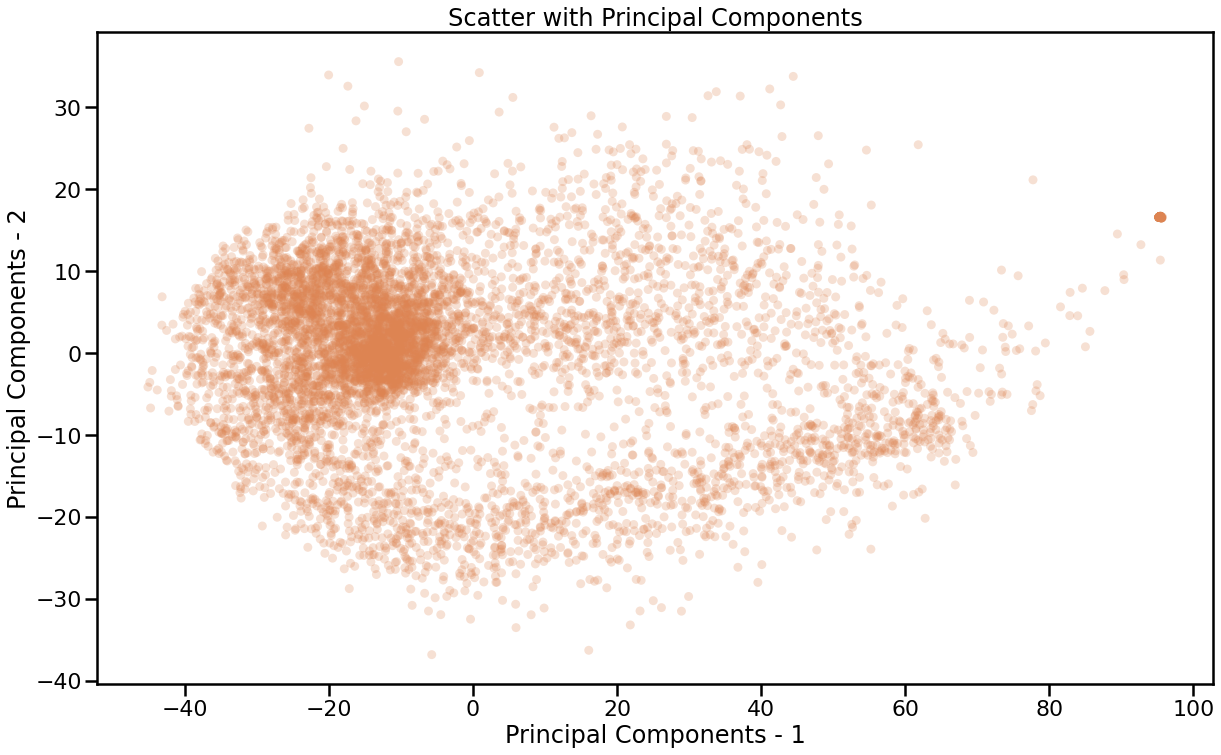

In [23]:
def visualize_PCA(data, labels, dim_name = 'Principal Components'):
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(True)
    frame.axes.get_yaxis().set_visible(True)
    plt.title('Scatter with {}'.format(dim_name))
    plt.xlabel(dim_name + " - 1")
    plt.ylabel(dim_name + " - 2")
    
    
    
d2sh = low_dim_embs[ind_2pca[:7000],:2]

# labels = np.ones((d2sh.shape[0],1), dtype=int)
labels = [int(1)]*d2sh.shape[0]

plt.figure(figsize=(20,12))
visualize_PCA(d2sh, labels)

# d2sh_svd = low_dim_embs_svd[ind_2pca[:5000],:2]
# labels = [int(1)]*d2sh_svd.shape[0]

# plt.figure(figsize=(26,13))
# visualize_PCA(d2sh_svd, labels)


## Clustering : KM / AC

In [72]:
n_clusters = 8
# THE MORE SAMPLES TO CLUSTER, THE MORE SIMILAR RESULTS 
# - OBTAINED BY WITH ORIGINAL DATA AND BY PCA
n_2cluster = min(len(ind_2pca), 10000)
n_2plot = 5000

In [73]:


# ind_only = np.random.permutation(data.shape[0])
# ind_only = ind_only[:plot_only]

# from sklearn.mixture import gaussian_mixture
# labels, timecomsump, algorithm = do_clustering(low_dim_embs[ind_only,:2], 
#                                                gaussian_mixture.GaussianMixture, (), 
#                                                {'n_components':6, 'covariance_type':'diag'})

#################
# labels, timecomsump, algorithm = do_clustering(data2[ind_only,6:], cluster.KMeans, (), {'n_clusters':6})
labels_or, timecomsump_or \
    = do_clustering(data[ind_2pca[:n_2cluster],:], cluster.AgglomerativeClustering, (), 
                {'n_clusters':n_clusters, 'linkage':'ward'})

In [74]:

labels_pc, timecomsump_pc \
    = do_clustering(low_dim_embs[ind_2pca[:n_2cluster],:2], cluster.AgglomerativeClustering, (), 
                {'n_clusters':n_clusters, 'linkage':'ward'})


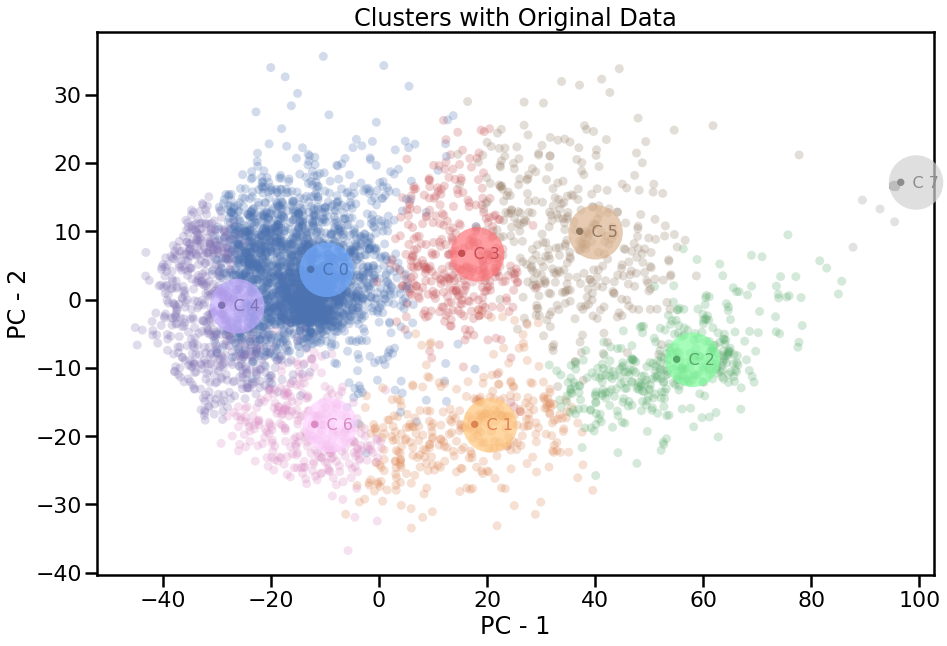

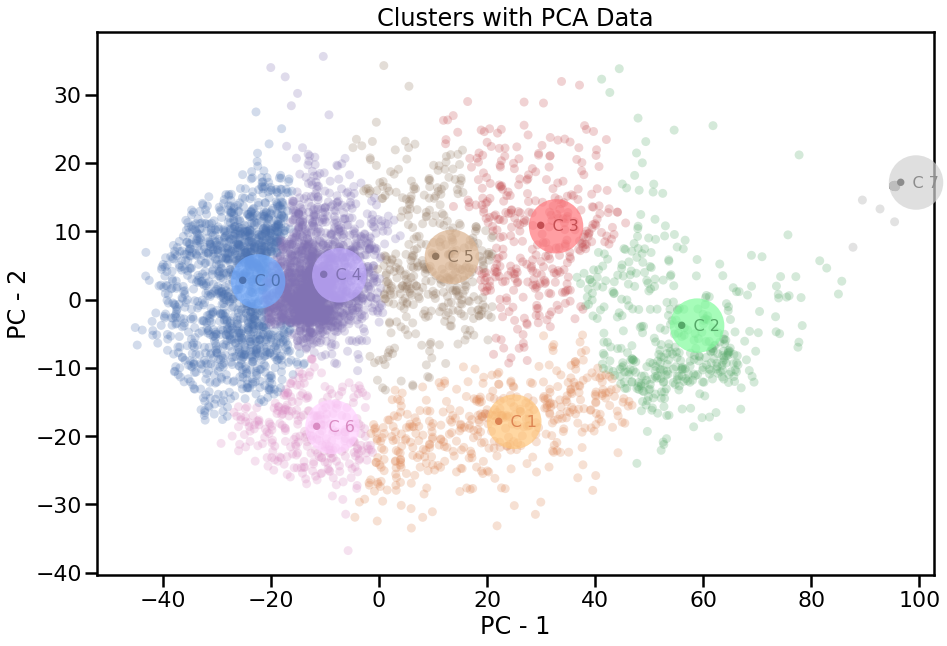

In [75]:
# algorithm.predict(data[ind_only])
fig = plt.figure(figsize = (15,10))
palette_or = plot_clusters(low_dim_embs[ind_2pca[:n_2plot],0:3], labels_or[:n_2plot], alg_name="Original Data")
# plt.savefig(os.path.join("results", "cluster_scatter_nc%d_or.png"%n_clusters))

fig = plt.figure(figsize = (15,10))
palette_pc = plot_clusters(low_dim_embs[ind_2pca[:n_2plot],0:3], labels_pc[:n_2plot], alg_name="PCA Data", palette=palette_or)

# plt.savefig(os.path.join("results", "cluster_scatter_nc%d_pc.png"%n_clusters))


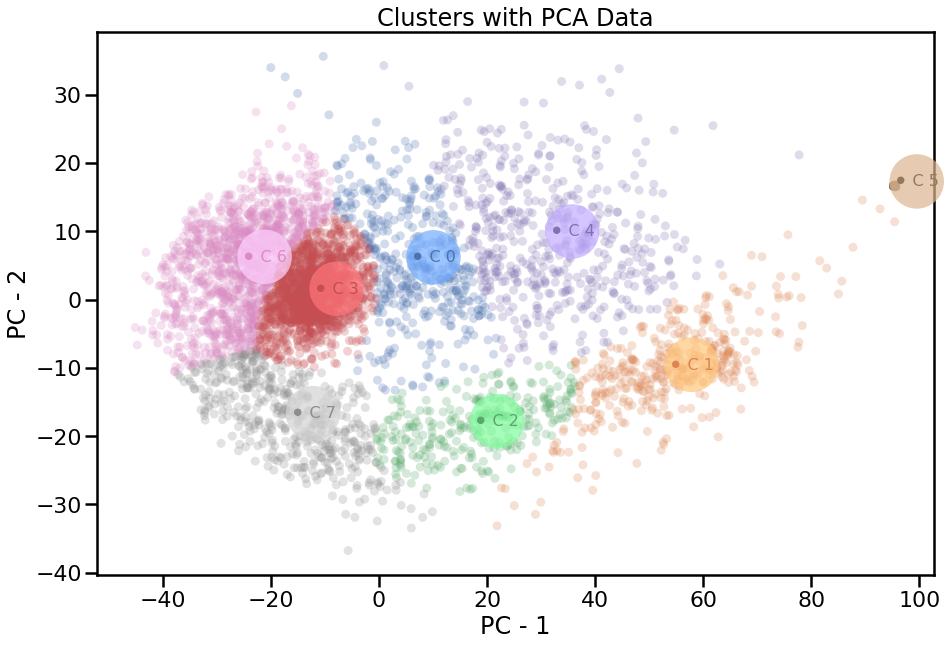

In [103]:
from sklearn.mixture import GaussianMixture
cluster.
GM = GaussianMixture(n_components=n_clusters, covariance_type='full')
GM.fit(low_dim_embs[ind_2pca[:n_2cluster],:2])
labels_gm = GM.predict(low_dim_embs[ind_2pca[:n_2cluster],:2])

fig = plt.figure(figsize = (15,10))
palette_pc = plot_clusters(low_dim_embs[ind_2pca[:n_2plot],0:3], labels_gm[:n_2plot], alg_name="PCA Data", palette=palette_or)

# plt.savefig(os.path.join("results", "cluster_scatter_nc%d_pc.png"%n_clusters))

### Visualize the obtained reflectances


In [67]:
def plot_reflectances(frequqencies, reflectances, colors = "None",src_data="None"):
    
    if colors == "None":
        colors = sns.color_palette('deep', reflectances.shape[0] + 1)
        # colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    if len(frequqencies) != reflectances.shape[1]:
        print("Dimensions of X and Y to plot are not consistent")
    
    if reflectances.shape[0]%3 == 0:
        fig_height = (reflectances.shape[0]//3)*7
    else:
        fig_height = (reflectances.shape[0]//3+1)*7
    fig, axes = plt.subplots((reflectances.shape[0]//3+1*(reflectances.shape[0]%3!=0) ), 3, 
                            figsize=(21,fig_height))
    for i in range(reflectances.shape[0]):
        if i > reflectances.shape[0]:
            break
        if reflectances.shape[0]==3:
            ax = axes[i]
        if reflectances.shape[0]>3:
            ax = axes[i//3, i%3]
        if reflectances.shape[0]<3:
            print("please set cluster number greater than 2.")
            return
        
        ax.plot(frequqencies[6:]/1000, reflectances.T[6:,i], color = colors[i])
        ax.set_title("C " +str(i),color=colors[i])
        if i%3 == 0:
            ax.set_ylabel("Reflectance")
        if 0<=(i-(reflectances.shape[0]//3)*3)<=3:
            ax.set_xlabel("Frequency/KHz")
        if (reflectances.shape[0]//3+1*(reflectances.shape[0]%3!=0) )*3 == reflectances.shape[0]:
            if -3<=(i-(reflectances.shape[0]//3)*3)<=0:
                ax.set_xlabel("Frequency/KHz")
    if src_data is not None:
        plt.suptitle("Cluster Reflectances - %s Data"%src_data)

    
    
def get_reflectances_of_clusters(data, ind, label, is_show = False):
    reflectances =[]
    [reflectances.append(data[ind_2pca[np.where(label==v)], :].mean(axis=0)) for v in np.unique(label)]
    reflectances =np.array(reflectances)

    if is_show:
        fre_relevant = np.array(range(54000,78001,1000)) #[v for v in range (54000, 78001, 1000)]

#         fig, axes = plt.subplots(1, 3, figsize=(21,7))
#         for i, ax in enumerate(axes):
#             ind_cluster = ind_2pca[np.where(label==i)]
#             ax.plot(fre_relevant[6:], data[ind_cluster[:200], :].T[6:])
#             ax.set_title("C " +str(i))

        if reflectances.shape[0]%3 == 0:
            fig_height = (reflectances.shape[0]//3)*7
        else:
            fig_height = (reflectances.shape[0]//3+1)*7
        fig, axes = plt.subplots((reflectances.shape[0]//3+1*(reflectances.shape[0]%3!=0) ), 3, 
                                figsize=(21,fig_height))
        for i in range(reflectances.shape[0]):
            if i > reflectances.shape[0]:
                break
            if reflectances.shape[0]==3:
                ax = axes[i]
            if reflectances.shape[0]>3:
                ax = axes[i//3, i%3]
            if reflectances.shape[0]<3:
                print("please set cluster number greater than 2.")
                return

            ind_cluster = ind_2pca[np.where(label==i)]
            ax.plot(fre_relevant[6:], data[ind_cluster[:1000], :].T[6:], linewidth=1)
            
            ax.set_title("C " +str(i))
            if i%3 == 0:
                ax.set_ylabel("Reflectance")
            if 0<=(i-(reflectances.shape[0]//3)*3)<=3:
                ax.set_xlabel("Frequency/KHz")
            if (reflectances.shape[0]//3+1*(reflectances.shape[0]%3!=0) )*3 == reflectances.shape[0]:
                if -3<=(i-(reflectances.shape[0]//3)*3)<=0:
                    ax.set_xlabel("Frequency/KHz")
    
    return reflectances
    

#     plot_reflectances(frequqencies, reflectances_or, colors = palette_or)
#     plt.suptitle("Cluster Reflectances with Original Data")
#     plt.savefig(os.path.join("results","frequencies_nc%d_ori.png"%n_clusters))

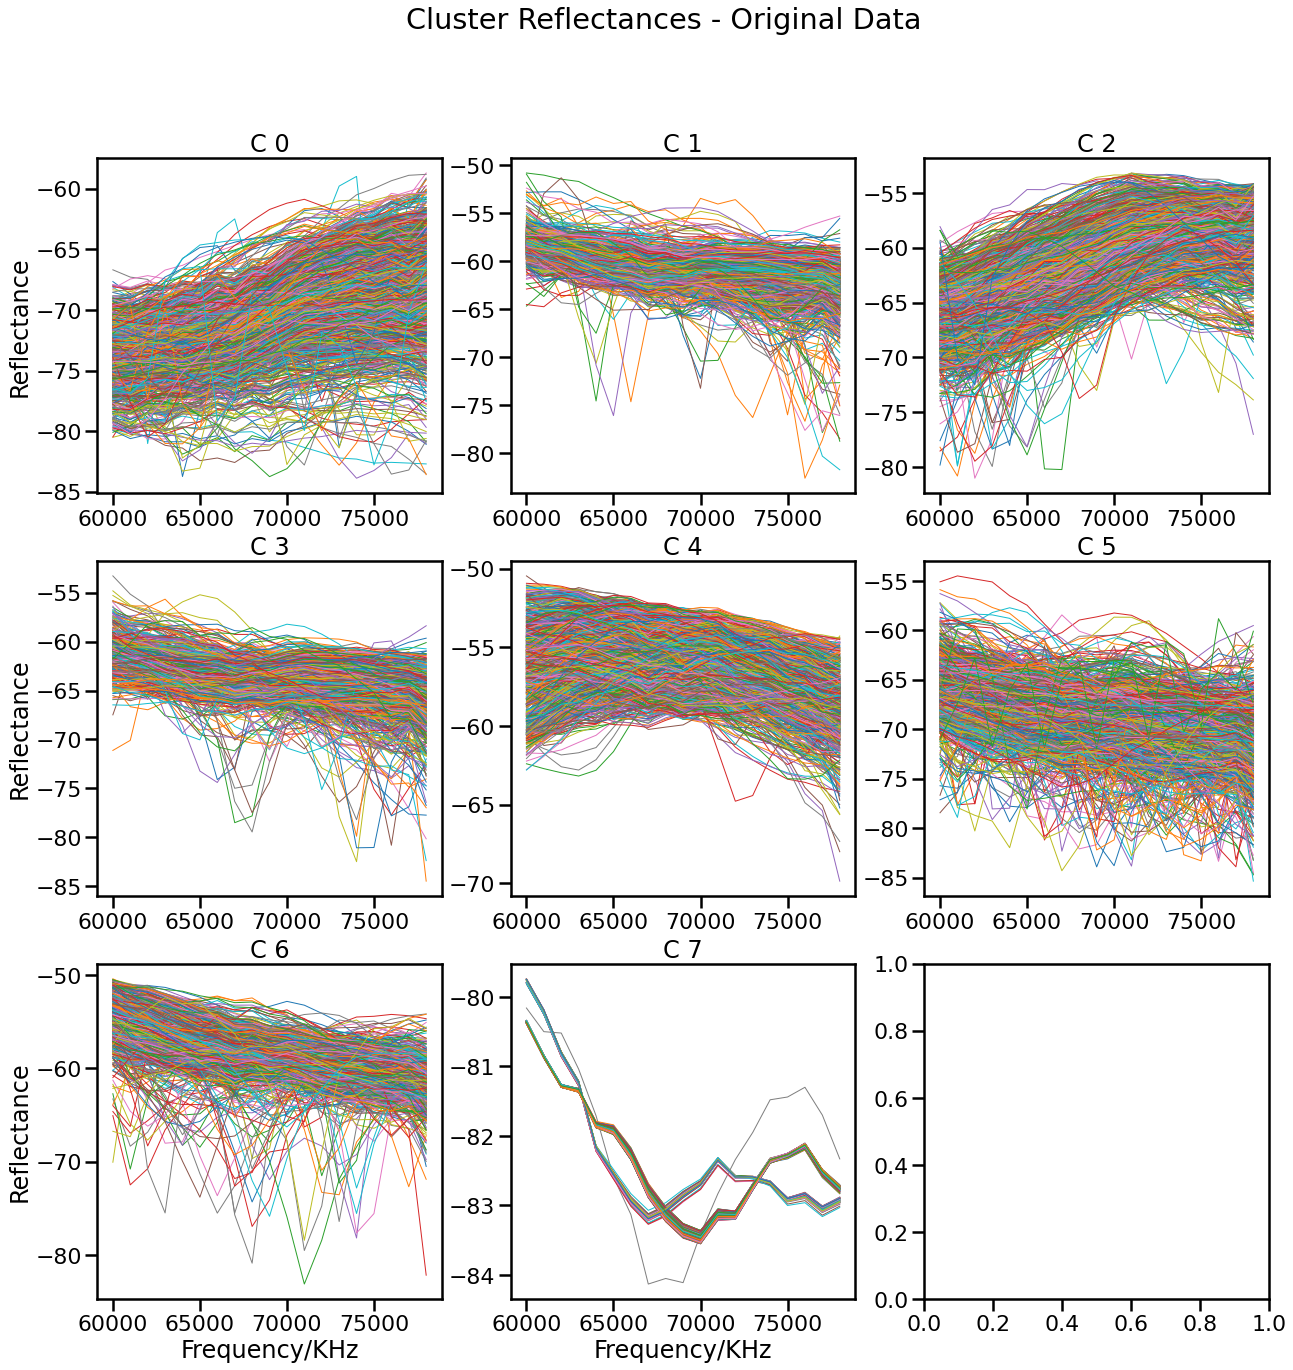

In [68]:
_ = get_reflectances_of_clusters(data, ind_2pca, labels_or, is_show=True)
_ = plt.suptitle("Cluster Reflectances - Original Data")
plt.savefig(os.path.join("results","frequencies_nc%d_ori_all.png"%n_clusters))


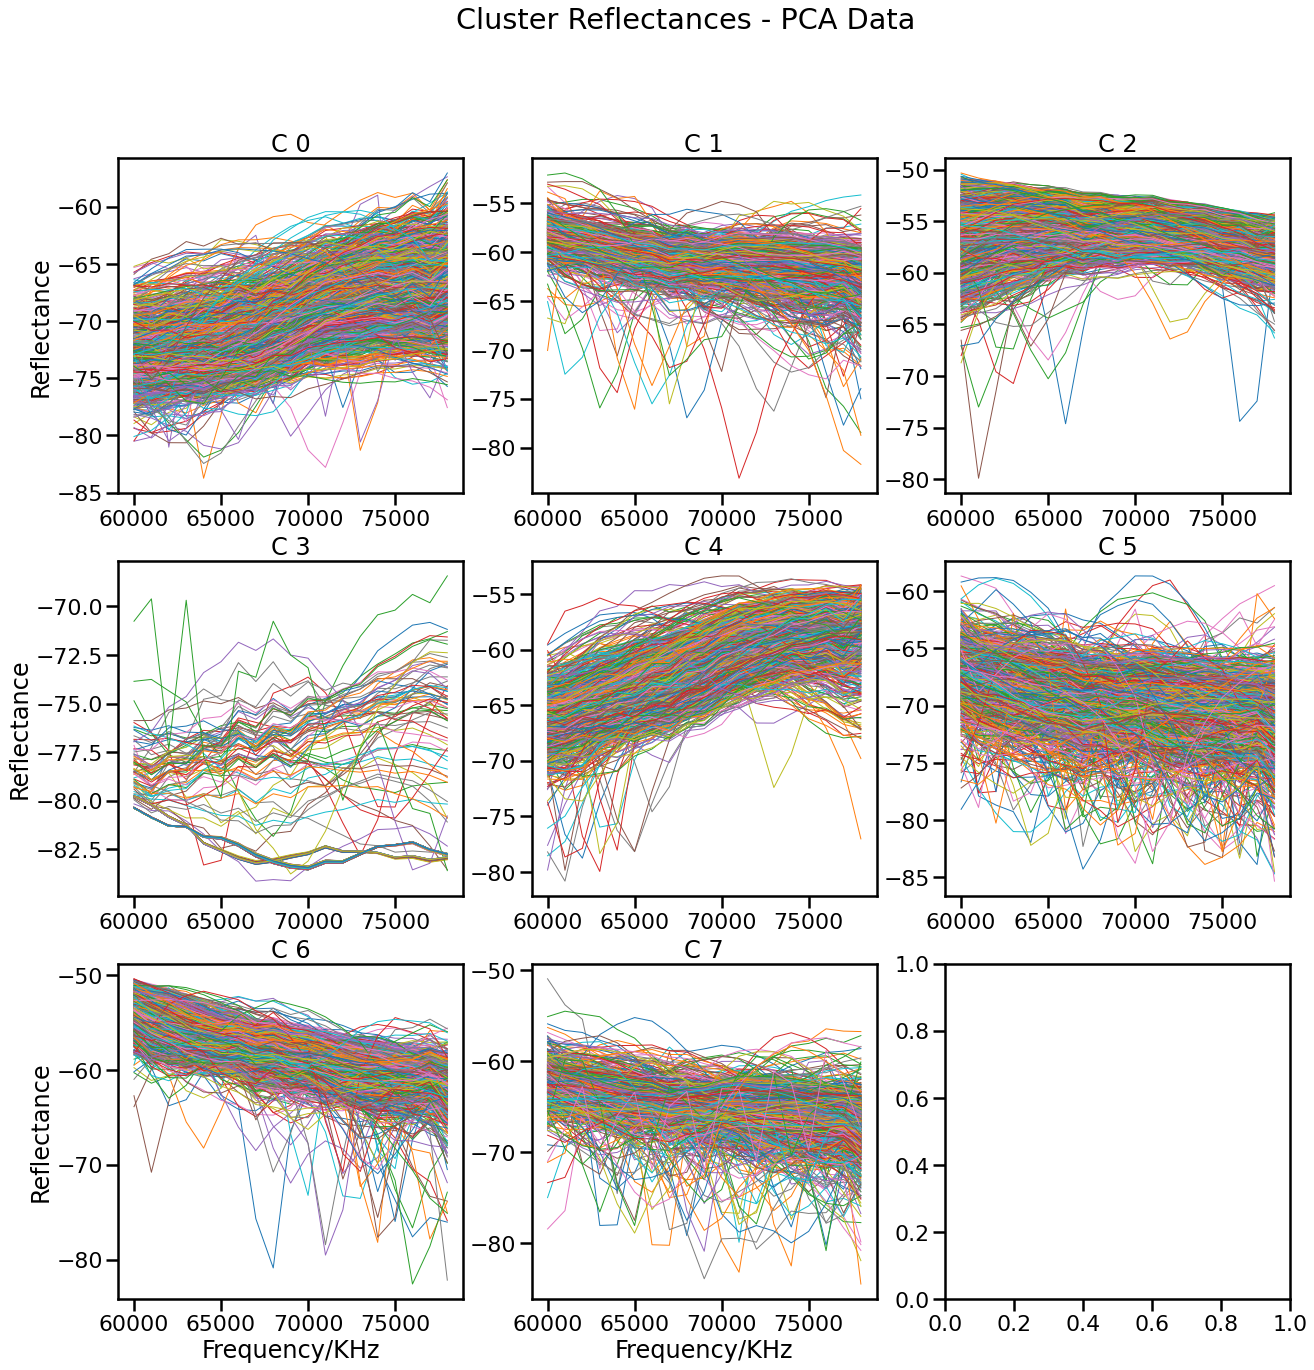

In [69]:
_ = get_reflectances_of_clusters(data, ind_2pca, labels_pc, is_show=True)
_ = plt.suptitle("Cluster Reflectances - PCA Data")
plt.savefig(os.path.join("results","frequencies_nc%d_pc_all.png"%n_clusters))


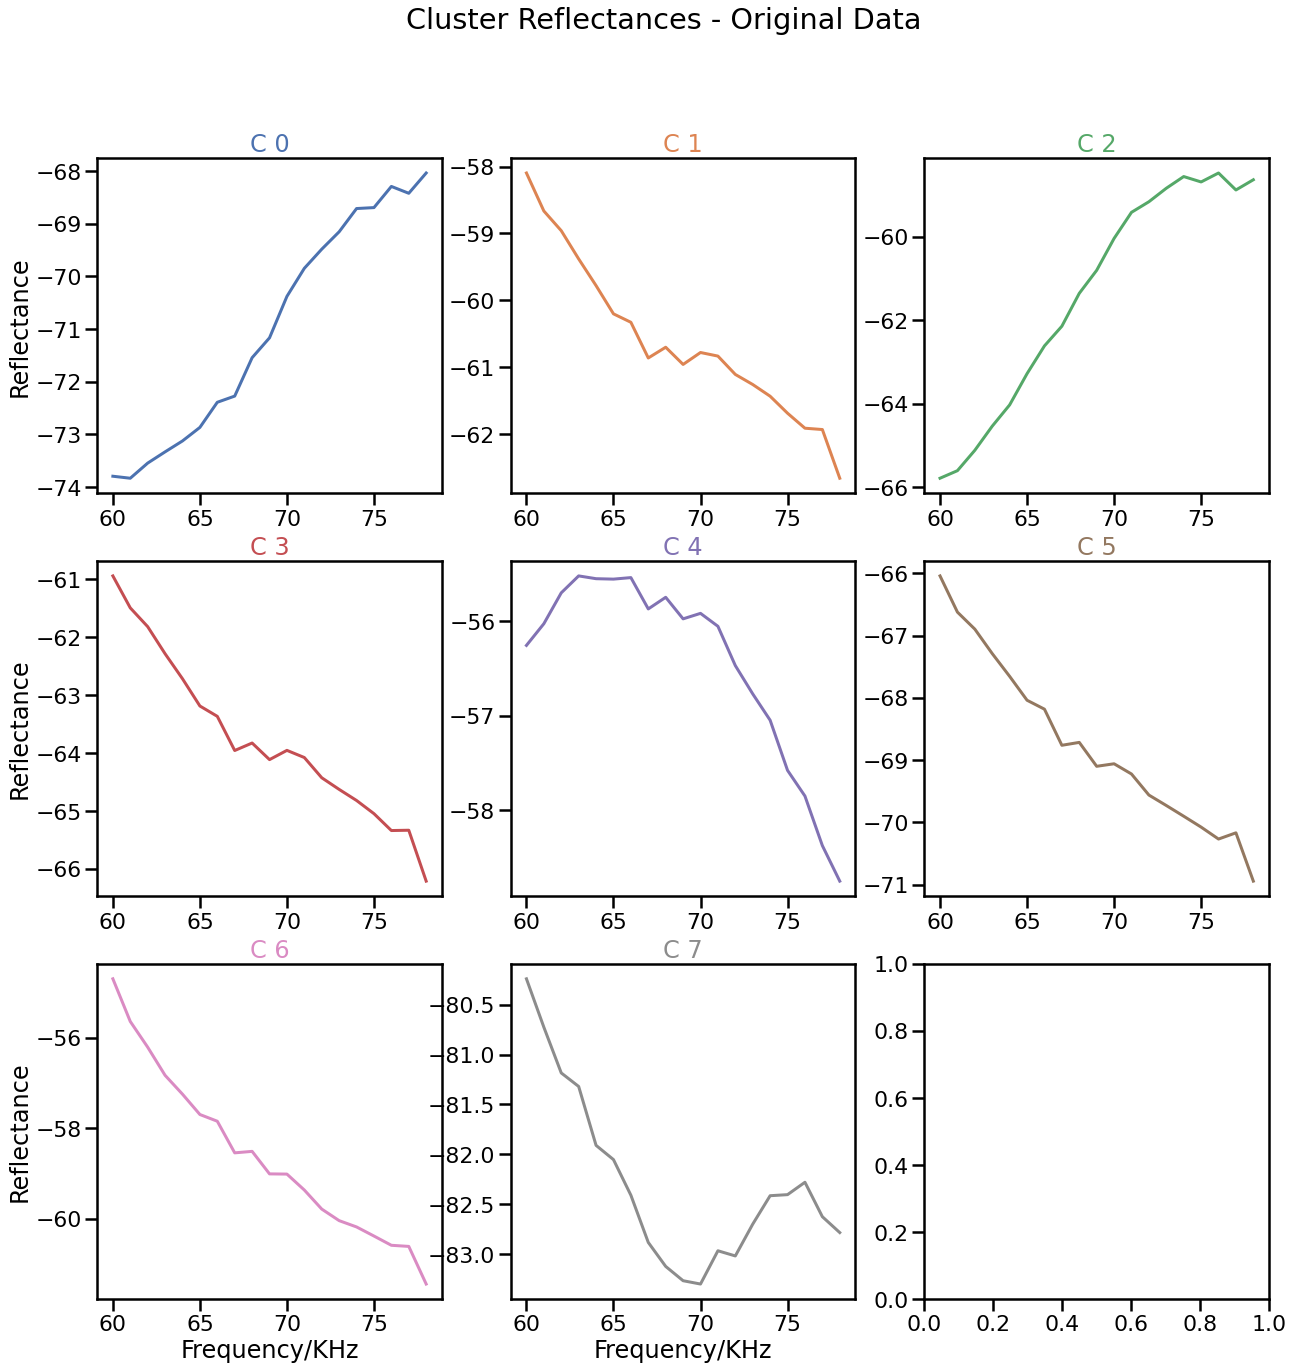

In [70]:
# n_clusters = 8
# # THE MORE SAMPLES TO CLUSTER, THE MORE SIMILAR RESULTS 
# # - OBTAINED BY WITH ORIGINAL DATA AND BY PCA
# n_2cluster = min(len(ind_2pca), 10000)
# n_2plot = 5000
# labels_or, labels_or
# reflectances_or =[]
# reflectances_pc =[]
# [reflectances_or.append(data[ind_2pca[np.where(labels_or==v)], :].mean(axis=0)) for v in np.unique(labels_or)]
# [reflectances_pc.append(data[ind_2pca[np.where(labels_pc==v)], :].mean(axis=0)) for v in np.unique(labels_pc)]

# reflectances_or =np.array(reflectances_or)
# reflectances_pc =np.array(reflectances_pc)

fre_relevant = np.array(range(54000,78001,1000)) #[v for v in range (54000, 78001, 1000)]

ref_or = get_reflectances_of_clusters(data, ind_2pca, labels_or)

plot_reflectances(fre_relevant, ref_or, colors = palette_or, src_data = "Original")
plt.savefig(os.path.join("results","frequencies_nc%d_ori.png"%n_clusters))


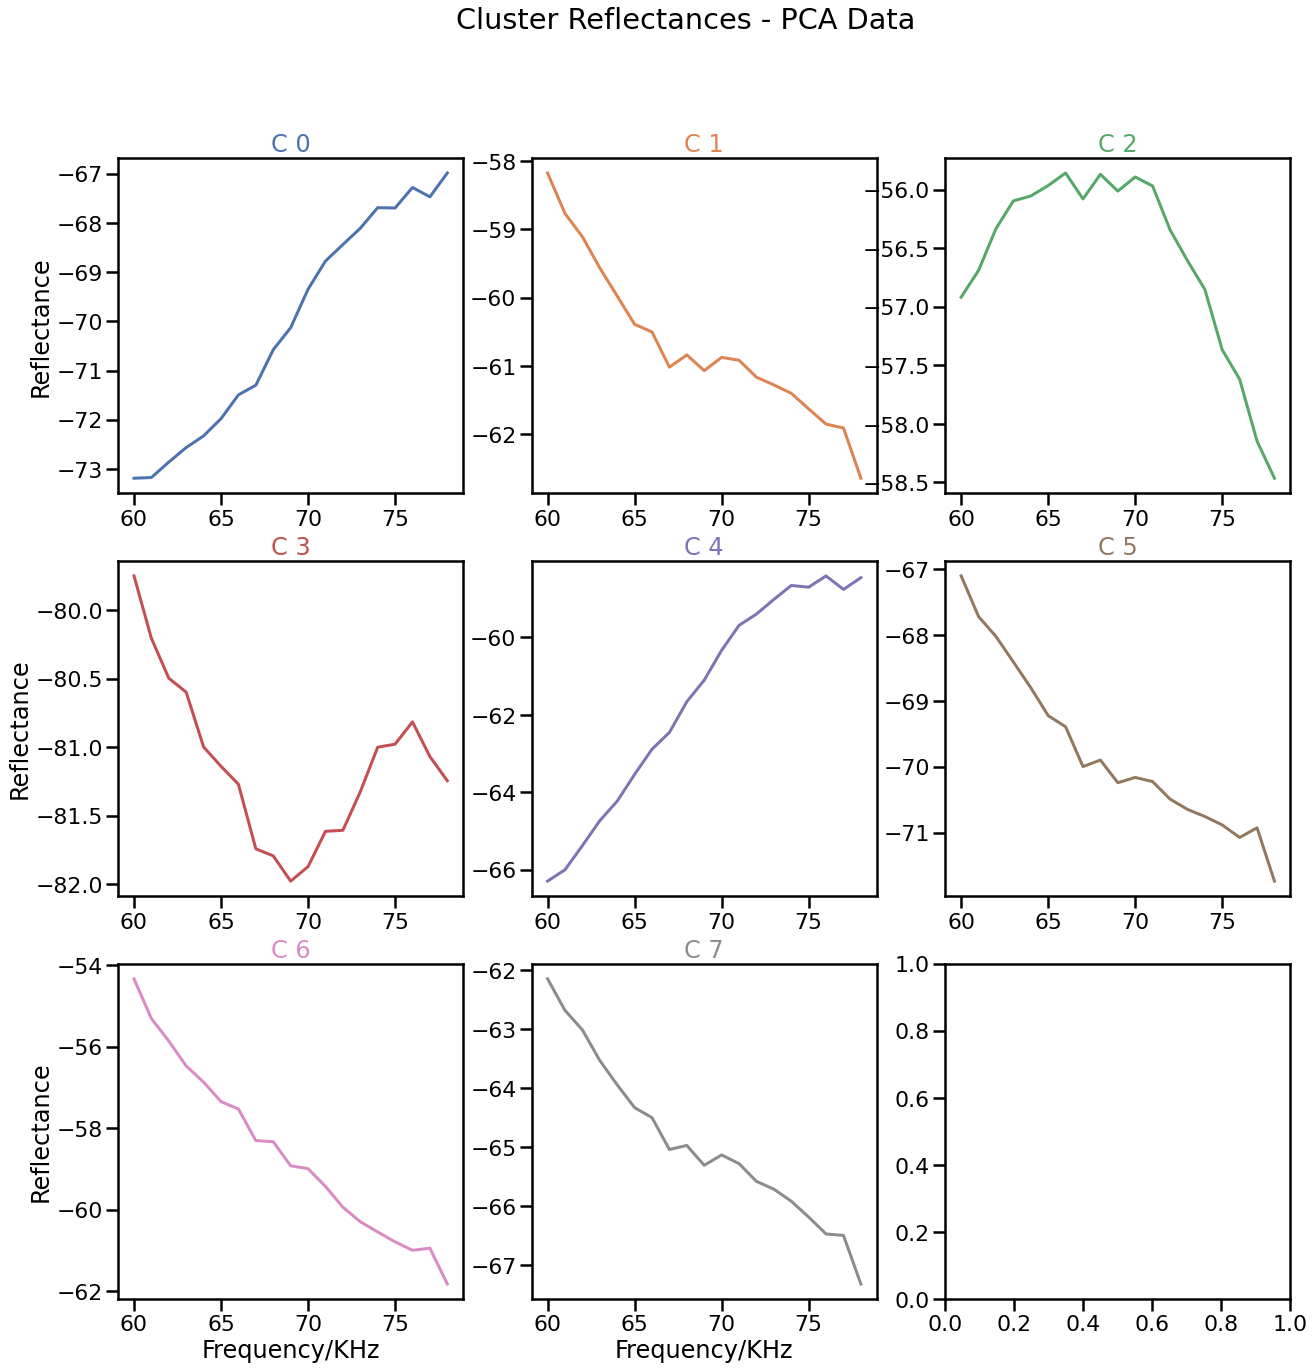

In [71]:
ref_pc = get_reflectances_of_clusters(data, ind_2pca, labels_pc)

plot_reflectances(fre_relevant, ref_pc, colors = palette_pc, src_data="PCA")

plt.savefig(os.path.join("results","frequencies_nc%d_pc.png"%n_clusters))

### Perform subset clustering, to check the consistency between multiple subsets

In [72]:
!pwd
if  os.path.basename(os.getcwd()) == "Clustering-Braodband-master":
    if not os.path.isdir(os.path.join(os.getcwd(),'subset_clustering')):
        os.makedirs('subset_clustering')

/Users/yi.liu/Dropbox/Work@IMR/Clustering-Braodband-master


In [73]:
# n_2pca = min( max(4000000,int(data.shape[0]*0.5)), data.shape[0])
# ind_perm = np.random.permutation(data.shape[0])
# ind_2pca = ind_perm[:n_2pca]
# pca= PCA(n_components=13)
# pca.fit(data[ind_2pca,:])
# low_dim_embs = pca.transform(data)

In [41]:
def plot_clusters_02(data, labels, alg_name = '', palette = None):
    
    if palette is None:
        palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
        
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(True)
    frame.axes.get_yaxis().set_visible(True)
    plt.xlabel("PC" + " - 1")
    plt.ylabel("PC" + " - 2")
    plt.title('Clusters with {}'.format(alg_name), fontsize=24)
    
    for i in np.unique(labels):
        plt.text(data.T[0,labels==i].mean(), data.T[1,labels==i].mean(), \
                 "\u26AB C " + str(i), color = [p for p in palette[i]], \
                 bbox=dict(facecolor=[min(p*1.5,1) for p in palette[i]], edgecolor='None',\
                           boxstyle = "Circle", alpha=0.7), fontsize=16)
        
    return palette

Batch-wise clustering

In [42]:
# from matplotlib import animation, rc
# from IPython.display import HTML, Image
# rc('animation', html='html5')

In [45]:
# turn off interactive plotting
# plt.ioff()

AC02 = cluster.Ag
def do_subset_clustering(Data, n_Cluster, index_perm, PCs2sh, batch_size, overlay_size, batch_max=None):
    
#     fig = plt.figure(figsize = (30,18))
    
    print('-'*60, '\t\tSubset clustering by patches ', '-'*60, sep='\n')
    
    if batch_max is None:
        batch_max = batch_size*3
    if batch_max > len(index_perm):
        batch_max = len(index_perm)
    
    for i in range(0, batch_max, batch_size):   #len(ind_perm)
        if i == 0: # adjust and use a big initial batch to decrease variation 
            indleft = 0
            indright= int(batch_size*1.5) - 1
            
        elif batch_max-batch_size*2 >=  i  > 0:
            indleft = i- overlay_size
            indright= i+ batch_size - 1
            
        elif batch_max-batch_size >= i > batch_max-batch_size*2 :  # last batch that is small is aggregated with the previous batch
            indleft = i- overlay_size
            indright= batch_max-1

        print(' '*7, 'Index [ {:6d}  -{:6d}]  of   Total {:6d}'.format(indleft, indright, batchmax))
        
        data_2cluster = Data[index_perm[indleft:indright],:]

#         labs_2plot, _ \
#             = do_clustering(data_2cluster, cluster.KMeans, (),
#                     {'n_clusters':n_Cluster})


        labs_2plot, _ \
            = do_clustering(data_2cluster, cluster.AgglomerativeClustering, (), 
                    {'n_clusters':n_Cluster, 'linkage':'ward'})

        _ = plot_clusters_02(PCs2sh[index_perm[indleft:indleft+min(5000, indright-indleft)],0:3], labs_2plot[:min(5000, indright-indleft)], 
                                   alg_name="Original Data")
        #     fig.canvas.draw()
        plt.savefig(os.path.join("subset_clustering", "subset_cluster_ori_nc%d_ind%d.png"%(n_Cluster, i)))
        #         plt.ioff()


In [47]:
batchsize = 5000
batchmax  = 300000
overlaysize = int(batchsize*0.5)
n_clusters = 10

fig = plt.figure(figsize = (35,21))
do_subset_clustering(data, n_clusters, ind_perm, low_dim_embs, batchsize, overlaysize, batch_max=batchmax)

In [ ]:
# turn off interactive plotting
# plt.ioff()

AC02 = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
sc = cluster.SpectralClustering(n_clusters=n_clusters, affinity='precomputed', 
                                n_init=100, assign_labels='discreteize')


def do_subset_clustering(Data, n_Cluster, index_perm, PCs2sh, batch_size, overlay_size, batch_max=None):
    
#     fig = plt.figure(figsize = (30,18))
    
    print('-'*60, '\t\tSubset clustering by patches ', '-'*60, sep='\n')
    
    if batch_max is None:
        batch_max = batch_size*3
    if batch_max > len(index_perm):
        batch_max = len(index_perm)
    
    for i in range(0, batch_max, batch_size):   #len(ind_perm)
        if i == 0: # adjust and use a big initial batch to decrease variation 
            indleft = 0
            indright= int(batch_size*1.5) - 1
            
        elif batch_max-batch_size*2 >=  i  > 0:
            indleft = i- overlay_size
            indright= i+ batch_size - 1
            
        elif batch_max-batch_size >= i > batch_max-batch_size*2 :  # last batch that is small is aggregated with the previous batch
            indleft = i- overlay_size
            indright= batch_max-1

        print(' '*7, 'Index [ {:6d}  -{:6d}]  of   Total {:6d}'.format(indleft, indright, batchmax))
        
        data_2cluster = Data[index_perm[indleft:indright],:]

#         labs_2plot, _ \
#             = do_clustering(data_2cluster, cluster.KMeans, (),
#                     {'n_clusters':n_Cluster})

        if i==0:
            AC02.fit(data_2cluster)
            labs_2plot = AC02.predict(data_2cluster)
        else:
            labs_2plot = AC02.preict(data_2cluster)
        
#         labs_2plot, _ \
#             = do_clustering(data_2cluster, cluster.AgglomerativeClustering, (), 
#                     {'n_clusters':n_Cluster, 'linkage':'ward'})

        _ = plot_clusters_02(PCs2sh[index_perm[indleft:indleft+min(5000, indright-indleft)],0:3], labs_2plot[:min(5000, indright-indleft)], 
                                   alg_name="Original Data")
        #     fig.canvas.draw()
#         plt.savefig(os.path.join("subset_clustering", "subset_cluster_ori_nc%d_ind%d.png"%(n_Cluster, i)))
        #         plt.ioff()


In [221]:
FA = cluster.FeatureAgglomeration(n_clusters=7,compute_full_tree=True, linkage='ward')
FA.fit(data[ind_2pca[:n_2cluster],:])

X_reduced = FA.transform(data[ind_2pca[:n_2cluster]])


penguins=sns.load_dataset('penguins')
index = ['Feature '+str(i) for i in range(n_clusters)]
# df_X = pd.DataFrame.from_records(low_dim_embs[ind_2pca[:n_2plot],:3], 
#                                  columns=['Feature '+str(i+1) for i in range(3)])
# df_X = pd.DataFrame.from_records(data[ind_2pca[:n_2plot],19:25]) #, index=index)
df_X = pd.DataFrame.from_records(X_reduced[:n_2plot,:], 
                                 columns=['Feature '+str(i+1) for i in range(X_reduced.shape[1])])


df_X["labels"] = labels_or[:n_2plot]
df_X.head()

df_X.to_csv('FeatureAgglomeration.csv', index=False)


# sns.color_palette('pastel')
# g.fig.set_size_inches(20,20)
# g=sns.pairplot(df_X, diag_kind="hist", hue = 'labels', palette = 'colorblind',plot_kws={"s":3})

# # plt.scatter(X_reduced[:,1], X_reduced[:,2])
# # palette_pc = plot_clusters(low_dim_embs[ind_2pca[:n_2plot],0:3], labels_fa[:n_2plot], alg_name="PCA Data", palette=palette_or)


# plt.savefig(os.path.join("results", "cluster_scatter_FeatureAgglomeration_nc%d_pc.png"%n_clusters))

In [118]:
# do_subset_clustering(data, ind_perm, batchsize, overlaysize)

### Cluster all the data set
In thsi section, I'm trying to batch-cluster all the samples with making consistent their labels among the batches.

This is done for good reasons:
- 1) making possible to cluster all data that is too huge to feed an algorithm at once.
- 2) after random permutation + batch size big enough -> each batch-clustering provide quite similar results with close patterns.

A further guarantee is to detect anomaly/outlier and keep them specifically once occurred.

In [ ]:
num_class = 6

# ref = {}
# count = [0,0,0,0,0,0]

# for i, j in zip(labels, data2):
#     if str(i) not in ref.keys:
#         ref[str(i)].append(j)
#         count[i] = count[i]+1
# #     ref[i] = ref[i]+j
#     print(j)

ref1 =[]
count = 0

for i, v in enumerate(labels):
    if v == 76:
        ref1.append(list(data[ind_only[i],:]))
        count = count+1
# ref1_mean = [0]*data2.shape[1]
# ref1_mean = [np.array(e)/count + ref1_mean for e in ref1]
        
        
ref1_mean = np.mean(np.array(ref1), 0)

In [ ]:
ref1_mean

In [ ]:
plt.plot(ref1_mean[6:])

In [ ]:
plt.plot(ref1_mean)

In [ ]:
# plot_clusters(data[ind_only,5:8], labels2sh, timecomsump)


In [ ]:
#         labels, timecomsump = do_clustering(low_dim_embs[ind_only,0:7], cluster.AgglomerativeClustering, (), {'n_clusters':K, 'linkage':'ward'})